# Предсказание коэффициента восстановления золота из золотосодержащей руды

**Входные данные:**  
Данные с параметрами добычи и очистки.  
  
**Задача:**  
Подготовить прототип модели машинного обучения: модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  
  
Нужно спрогнозировать сразу две величины:  
- эффективность обогащения чернового концентрата rougher.output.recovery;  
- эффективность обогащения финального концентрата final.output.recovery.  

**Метрика качества**  
sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).  
  
  
**Описание данных:**  
  
*Технологический процесс*  
`Rougher feed` — исходное сырье  
`Rougher additions` (или `reagent additions`) — флотационные реагенты: Xanthate, Sulphate, Depressant   
  
  `Xanthate` — ксантогенат (промотер, или активатор флотации);  
  `Sulphate` — сульфат (на данном производстве сульфид натрия);  
  `Depressant` — депрессант (силикат натрия).    
  
`Rougher process` (англ. «грубый процесс») — флотация  
`Rougher tails` — отвальные хвосты  
`Float banks` — флотационная установка  
`Cleaner process` — очистка  
`Rougher Au` — черновой концентрат золота  
`Final Au` — финальный концентрат золота  
  
*Параметры этапов*  
`air amount` — объём воздуха  
`fluid levels` — уровень жидкости  
`feed size` — размер гранул сырья  
`feed rate` — скорость подачи  
  
**Наименование признаков**  
  
Наименование признаков должно быть такое:  
[этап].[тип_параметра].[название_параметра]  
*Пример: rougher.input.feed_ag*  
  
Возможные значения для блока [этап]:  
  `rougher` — флотация  
  `primary_cleaner` — первичная очистка  
  `secondary_cleaner` — вторичная очистка  
  `final` — финальные характеристики  
  
Возможные значения для блока [тип_параметра]: 
  
  `input` — параметры сырья  
  `output` — параметры продукта  
  `state` — параметры, характеризующие текущее состояние этапа  
  `calculation` — расчётные характеристики  

## Подготовка данных

### Открытие файлов, изучение общей информации

Импорт библиотек

In [1]:
#! pip install pandas-profiling

In [2]:
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline

import phik
from phik.report import plot_correlation_matrix
from phik import report

import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error, 
                             make_scorer)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

Откроем файлы:

In [3]:
try:
    data_train = (
        pd.read_csv('/Users/darakasina/Desktop/DS/Проекты/project_gold_recovery_kashina/gold_recovery_train_new.csv', sep=',')
    )
    data_test = (
        pd.read_csv('/Users/darakasina/Desktop/DS/Проекты/project_gold_recovery_kashina/gold_recovery_test_new.csv', sep=',')
    )
    data_full = (
        pd.read_csv('/Users/darakasina/Desktop/DS/Проекты/project_gold_recovery_kashina/gold_recovery_full_new.csv', sep=',')
    )
    
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', sep=',')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', sep=',')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', sep=',')

Изучим общую информацию о полученных датафреймах:

In [4]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


План действий для предобработки данных и промежуточные выводы:  
1) `date` перевести в формат datetime. 
2) Не для всех веществ указаны концентрации в финальном концентрате  
3) Эффективность обогащения `recovery` не зависит от концентраций других веществ (точнее от наличия данных по ним)   
4) Пропуски в данных необходимо анализировать отдельно, параллельно смотреть на зависимости и отдельно этапы

Test и train в той или иной степени содержат те же данные, что и полный датасет. Для интереса посмотрим расхождение по колонкам train и test. Кроме этого:  
1) В test нужно добавить rougher.output.recovery и final.output.recovery - таргеты из full  
2) Из train нужно удалить все столбцы, которых нет в test (см. выше). 

Для начала сделаем дату индексами всех датафреймов:

In [5]:
data_list = [data_full, data_train, data_test]

for i in range(len(data_list)):
    data_list[i]['date'] = pd.to_datetime(
            data_list[i]['date'], format='%Y-%m-%d %H:%M:%S'
        )
    
data_full = data_full.set_index('date')
data_train = data_train.set_index('date')
data_test = data_test.set_index('date')

Добавим в test нужно добавить rougher.output.recovery и final.output.recovery - таргеты из full:

In [6]:
data_test['rougher.output.recovery'] = data_full.loc[data_full.index.isin(data_test.index)]['rougher.output.recovery']

print(data_test['rougher.output.recovery'].head())
data_full[data_full.index.isin(data_test.index)]['rougher.output.recovery'].head()

date
2016-09-01 00:59:59    89.993421
2016-09-01 01:59:59    88.089657
2016-09-01 02:59:59    88.412756
2016-09-01 03:59:59    87.360133
2016-09-01 04:59:59    83.236367
Name: rougher.output.recovery, dtype: float64


date
2016-09-01 00:59:59    89.993421
2016-09-01 01:59:59    88.089657
2016-09-01 02:59:59    88.412756
2016-09-01 03:59:59    87.360133
2016-09-01 04:59:59    83.236367
Name: rougher.output.recovery, dtype: float64

In [7]:
data_test['final.output.recovery'] = data_full.loc[data_full.index.isin(data_test.index)]['final.output.recovery']

print(data_test['final.output.recovery'].head())
data_full[data_full.index.isin(data_test.index)]['final.output.recovery'].head()

date
2016-09-01 00:59:59    70.273583
2016-09-01 01:59:59    68.910432
2016-09-01 02:59:59    68.143213
2016-09-01 03:59:59    67.776393
2016-09-01 04:59:59    61.467078
Name: final.output.recovery, dtype: float64


date
2016-09-01 00:59:59    70.273583
2016-09-01 01:59:59    68.910432
2016-09-01 02:59:59    68.143213
2016-09-01 03:59:59    67.776393
2016-09-01 04:59:59    61.467078
Name: final.output.recovery, dtype: float64

Проверим расхождение по столбцам:

In [8]:
train_col_list = list(data_train.columns)
test_col_list = list(data_test.columns)

mismatches_train_test = []

for i in range(len(train_col_list)):
    if train_col_list[i] not in test_col_list:
        mismatches_train_test.append(train_col_list[i])

        
print(f'Всего столбцов в train: {len(train_col_list)}')
print(f'Всего столбцов в test: {len(test_col_list)}')
print('Следующих столбцов нет в датафрейме data_test: ')
mismatches = pd.DataFrame(mismatches_train_test, columns=['train_test_mismatches'])

mismatches

Всего столбцов в train: 86
Всего столбцов в test: 54
Следующих столбцов нет в датафрейме data_test: 


train_test_mismatches
0                         final.output.concentrate_ag
1                         final.output.concentrate_pb
2                        final.output.concentrate_sol
3                         final.output.concentrate_au
4                                final.output.tail_ag
5                                final.output.tail_pb
6                               final.output.tail_sol
7                                final.output.tail_au
8               primary_cleaner.output.concentrate_ag
9               primary_cleaner.output.concentrate_pb
10             primary_cleaner.output.concentrate_sol
11              primary_cleaner.output.concentrate_au
12                     primary_cleaner.output.tail_ag
13                     primary_cleaner.output.tail_pb
14                    primary_cleaner.output.tail_sol
15                     primary_cleaner.output.tail_au
16      rougher.calculation.sulfate_to_au_concentrate
17  rougher.calculation.floatbank10_sulfate_to_au_...
18  rougher.calculation.floatbank11_sulfate_to_au_...
19                    rougher.calculation.au_pb_ratio
20                      rougher.output.concentrate_ag
21                      rougher.output.concentrate_pb
22                     rougher.output.concentrate_sol
23                      rougher.output.concentrate_au
24                             rougher.output.tail_ag
25                             rougher.output.tail_pb
26                            rougher.output.tail_sol
27                             rougher.output.tail_au
28                   secondary_cleaner.output.tail_ag
29                   secondary_cleaner.output.tail_pb
30                  secondary_cleaner.output.tail_sol
31                   secondary_cleaner.output.tail_au

То есть в тесте нет output по всем этапам, также нет расчетных характеристик этапа флотации. Это значит, что расчетные характеристики этапа флотации можно убрать из всех датафреймов - по этим признакам мы все равно не сможем сделать предсказание в test.  

Из train удалим все столбцы, которых нет в test:

In [9]:
data_train = data_train.drop(columns = list(mismatches.train_test_mismatches))

print(f'Всего столбцов в train: {len(list(data_train.columns))}')
print(f'Всего столбцов в test: {len(list(data_test.columns))}')

Всего столбцов в train: 54
Всего столбцов в test: 54


Построим профайл для data_train для выявления зависимостей и интересных особенностей:

In [10]:
profile = ProfileReport(data_train, progress_bar=False, minimal=True)
profile

1) 0,3% пропусков    
2) 1 категориальная переменная (date), нет повторяющихся значений (можно использовать как индексы)  
3) Пропуски:  
 
final.output.concentrate_ag - 1 пропущенное значение - удалить  
final.output.concentrate_pb - 1 пропущенное значение - удалить  
  
4) Нулевые значения:  
  
final.output.concentrate_ag - 58 нулей (0.4%)  
final.output.concentrate_pb - 58 нулей (0.4%)  
final.output.concentrate_sol - 58 нулей (0.4%)  
final.output.concentrate_au - 58 нулей (0.4%)  
final.output.recovery - 58 нулей (0.4%)  
Скорее всего в одних и тех же строках.  
  
final.output.tail_ag - 75 нулей (0.5%)  
final.output.tail_pb - 75 нулей (0.5%)  
final.output.tail_sol - 75 нулей (0.5%)  
final.output.tail_au - 75 нулей (0.5%)  
  
rougher.output.concentrate_ag - 297 нулей (2.1%)  
rougher.output.concentrate_pb - 297 нулей (2.1%)  
rougher.output.concentrate_sol - 297 нулей (2.1%)  
rougher.output.concentrate_au - 297 нулей (2.1%)  
rougher.output.recovery - 297 нулей (2.1%)  
Скорее всего в одних и тех же строках. Нужно проверить и, вероятно, удалить, т.к. На нулях мы корректно модель не обучим. Либо заполнить рандомными данными.  
  
secondary_cleaner.output.tail_ag - 739 нулей (5.2%)  
secondary_cleaner.output.tail_pb - 739 нулей (5.2%)  
secondary_cleaner.output.tail_sol - 739 нулей (5.2%)  
secondary_cleaner.output.tail_au - 739 нулей (5.2%)  
Также скорее всего в одних и тех же строках - проверить. В принципе, тест мы в реальности тоже можем предобработать. Либо научиться выдавать ошибку на таких данных.  
  
5) final.output.concentrate_ag  
Гистограмма, чуть скошенная вправо. Выбросы около нуля.  
  
final.output.concentrate_pb  
Гистограмма, скошенная влево. Выбросы около нуля.  
  
final.output.concentrate_sol  
Мультимодальная гистограмма, два далеко расположенных пика. Выяснить, откуда еще один пик.  
Выбросы около нуля.  
  
final.output.concentrate_au  
Сильно скошенная гистограмма влево с выбросами около нуля.  
  
final.output.recovery  
Скошенная влево гистограмма с выбросами около 0 и 100.  
  
final.output.tail_ag  
final.output.tail_sol  
final.output.tail_pb  
Мультимодальная гистограмма, два близко расположенных пика.  
  
primary_cleaner.input.depressant  
primary_cleaner.input.xanthate  
Мультимодальные гистограммы, много пиков.  
  
_air, _level  
Мультимодальные сильно скошенные влево гистограммы  
  
rougher.calculation.sulfate_to_au_concentrate  
rougher.calculation.floatbank10_sulfate_to_au_feed  
rougher.calculation.floatbank11_sulfate_to_au_feed  
rougher.input.floatbank11_sulfate  
огромный разброс значений  

Проверим Phik корреляцию (>0.7), у которой нет таких строгих предположений о том, что переменные распределены нормально и однородны. Она способна улавливать нелинейные взаимосвязи, которые будут моделироваться в линейной регрессии немного иначе в зависимости от характера взаимосвязи (то есть ели phik обнаруживает какую-то более сильную взаимосвязь, чем линейный corr, значит есть смысл изучить характер взаимосвязи подробнее и постараться его учесть при моделировании).

In [11]:
def plot_phik_overview(dataframe):
    phik_overview = dataframe.phik_matrix()

    mask = phik_overview >= 0.7
    filtered_phik = np.where(mask, phik_overview, 0)
    selected_columns = phik_overview.columns[mask.any(axis=0)]

    figure, axes = plt.subplots(figsize=(15, 15))
    axes.matshow(filtered_phik, cmap='Pastel1_r')

    axes.set_xticks(np.arange(len(selected_columns)))
    axes.set_xticklabels(selected_columns, rotation=90)

    axes.set_yticks(np.arange(len(selected_columns)))
    axes.set_yticklabels(selected_columns)

    plt.title(r'correlation $\phi_K$ (filtered, >= 0.7)', fontsize=14)
    plt.tight_layout()
    plt.show()

interval columns not set, guessing: ['final.output.recovery', 'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.output.recovery', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.fl

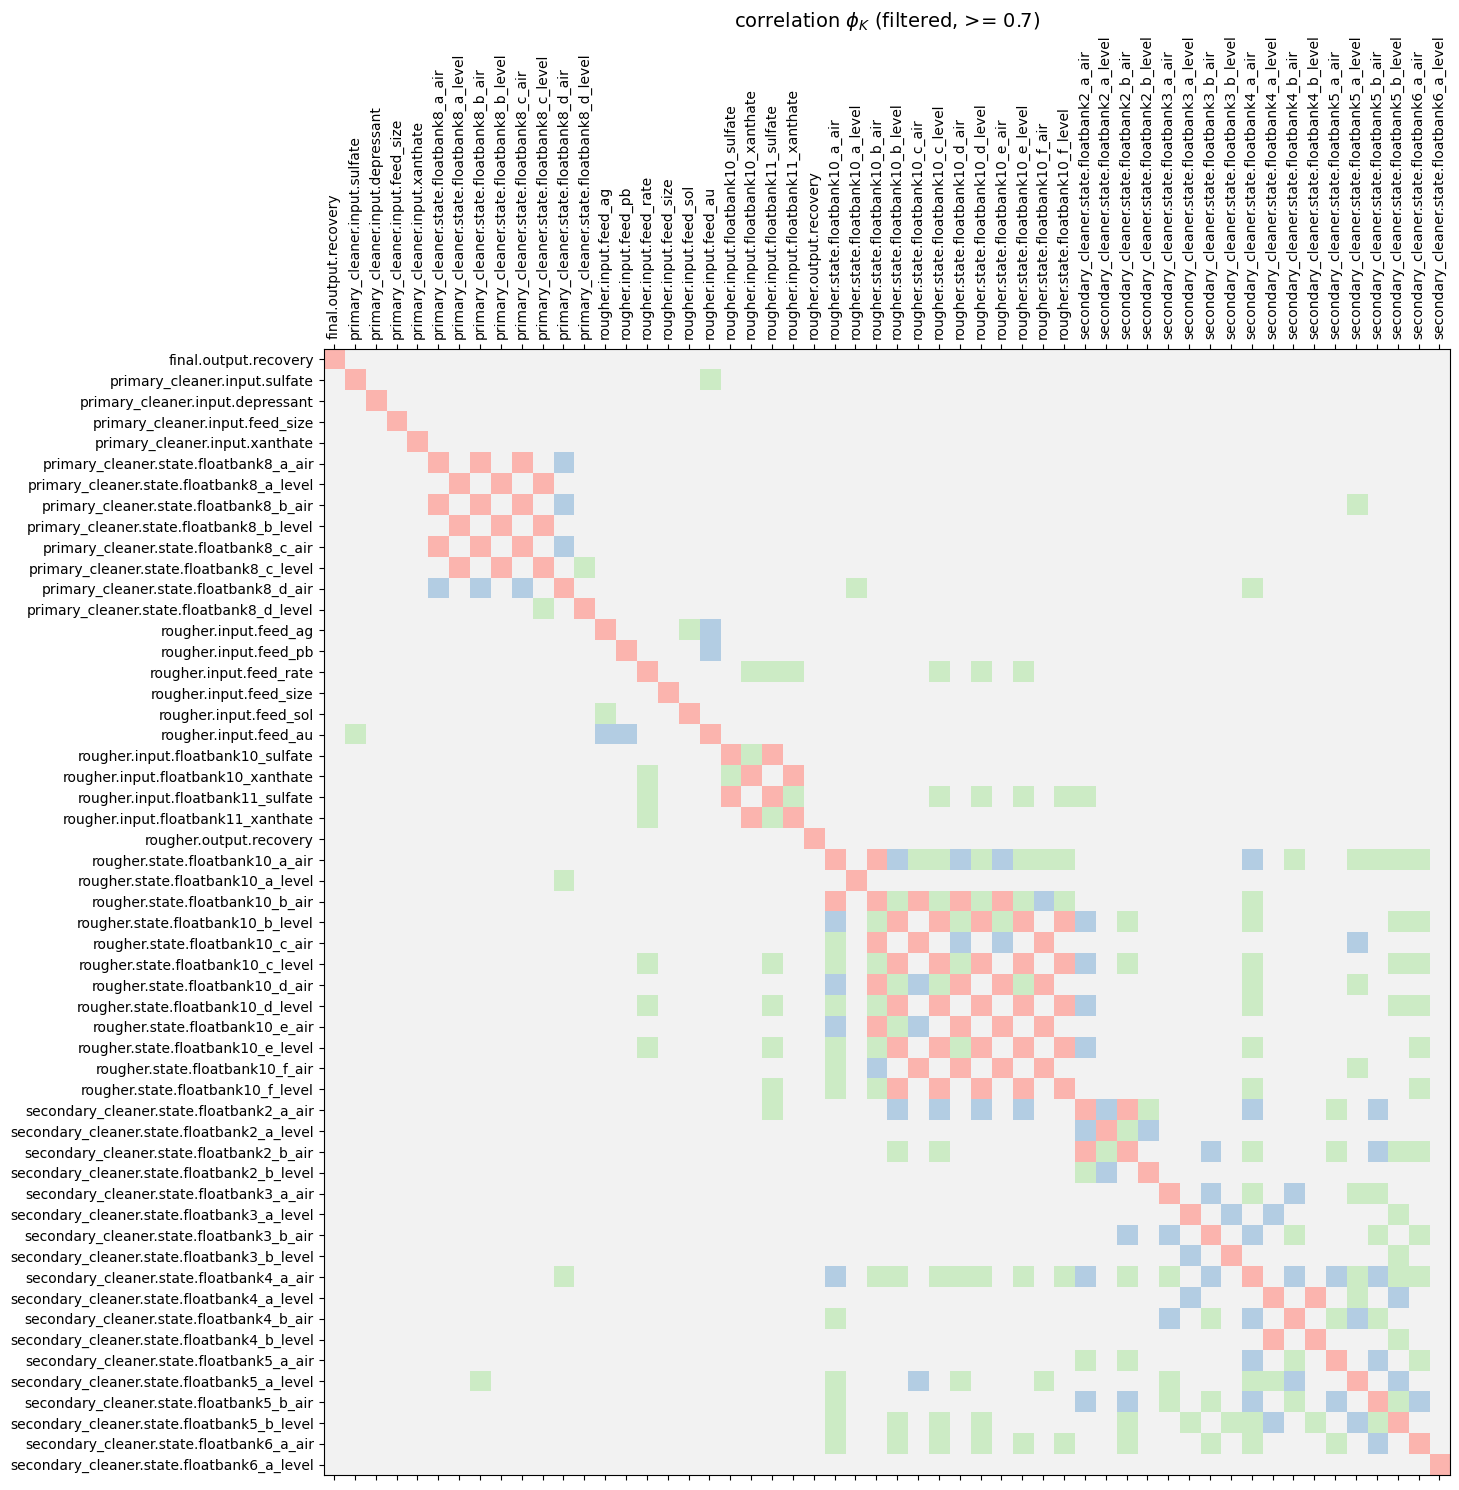

In [12]:
plot_phik_overview(data_train)

### Проверка расчета эффективности обогащения

Эффективность обогащения (таргет) у нас находится в столбце 'rougher.output.recovery'. Рассчитаем эффективность по заданным признакам по формуле:

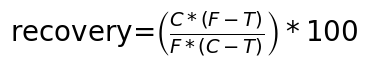

In [13]:
tex = 'recovery=$\\left(\\frac{C*(F-T)}{F*(C-T)}\\right)*100%/%$'

fig = plt.figure()
ax = fig.add_axes([0, 0, 0.01, 0.01])
ax.set_axis_off()

t = ax.text(0.1, 0.1, tex,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=20, color='black')

где:

C = rougher.output.concentrate_au  
F = rougher.input.feed_au  
T = rougher.output.tail_au  

In [14]:
data_train['rougher.output.concentrate_au'] = data_full.loc[data_full.index.isin(data_train.index)]['rougher.output.concentrate_au']
data_train['rougher.input.feed_au'] = data_full.loc[data_full.index.isin(data_train.index)]['rougher.input.feed_au']
data_train['rougher.output.tail_au'] = data_full.loc[data_full.index.isin(data_train.index)]['rougher.output.tail_au']

In [15]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']
data_train['rougher.calculation.recovery'] = (100*C*(F-T))/(F*(C-T))
MAE_rougher_recovery = mean_absolute_error(data_train['rougher.output.recovery'], 
                                                         data_train['rougher.calculation.recovery'])

MAE_rougher_recovery

1.151336351078093e-14

**Вывод**:  эффективность обогащения чернового концентрата `rougher.output.recovery` указана в датасете с точностью до 14-го знака после запятой. Мы можем опираться на `rougher.output.concentrate_au`, `rougher.input.feed_au`, `rougher.output.tail_au` при построении модели для предсказания эффективности обогащения чернового концентрата.

### Предобработка данных

Часть предобработки данных мы выполнили выше. Еще раз проверим отсутствие признаков в train, которых нет в test:

In [16]:
train_col_list = list(data_train.columns)
test_col_list = list(data_test.columns)

mismatches_train_test = []

for i in range(len(train_col_list)):
    if train_col_list[i] not in test_col_list:
        mismatches_train_test.append(train_col_list[i])

        
print(f'Всего столбцов в train: {len(train_col_list)}')
print(f'Всего столбцов в test: {len(test_col_list)}')
print('Следующих столбцов нет в датафрейме data_test: ')
mismatches = pd.DataFrame(mismatches_train_test, columns=['train_test_mismatches'])

mismatches

Всего столбцов в train: 57
Всего столбцов в test: 54
Следующих столбцов нет в датафрейме data_test: 


train_test_mismatches
0  rougher.output.concentrate_au
1         rougher.output.tail_au
2   rougher.calculation.recovery

Удалим все эти столбцы:

In [17]:
data_train = data_train.drop(columns = list(mismatches.train_test_mismatches))

print(f'Всего столбцов в train: {len(list(data_train.columns))}')
print(f'Всего столбцов в test: {len(list(data_test.columns))}')

Всего столбцов в train: 54
Всего столбцов в test: 54


Теперь без лишних данных вернемся к предобработке - в частности, обработаем пропуски и нулевые значения в признаках.

#### Обработка выбросов (нулей):

In [18]:
def replace_0_with_NaN (df): 
    df = df.replace(0, np.NaN) 
    return df

In [19]:
replace_0_with_NaN(data_train);

#### Обработка пропусков train

In [20]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (20,20), rot = 0, legend = False, fontsize = 16)
            .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('Пропусков не осталось')

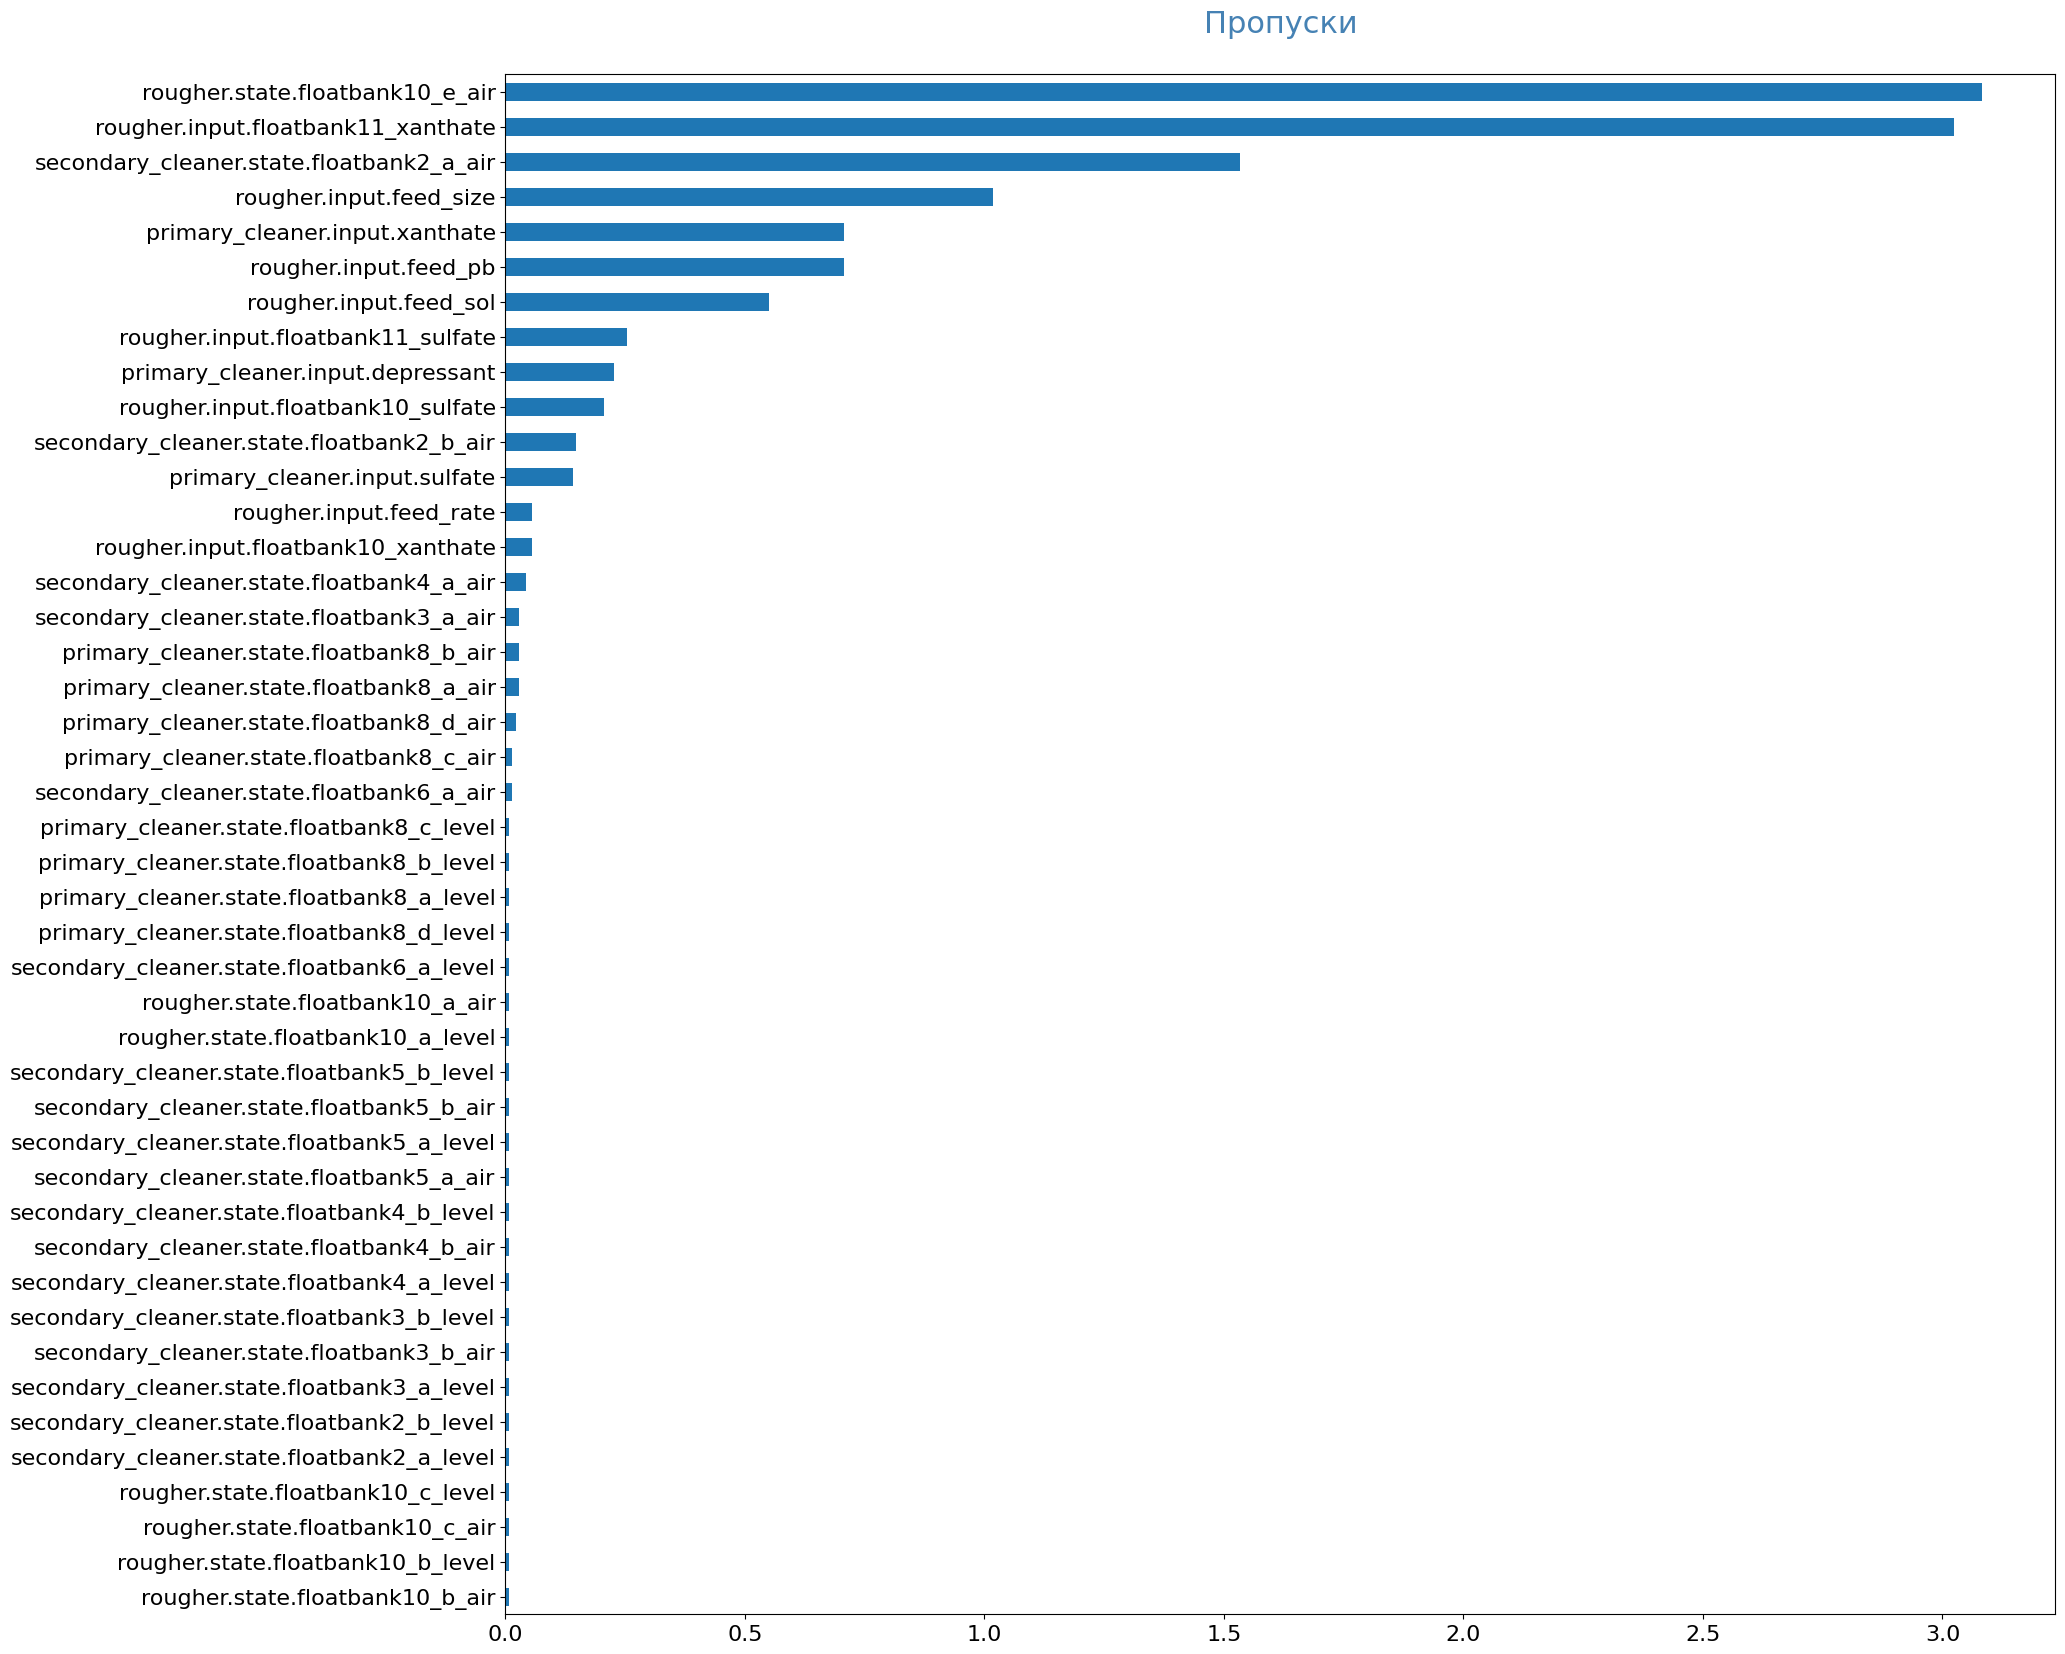

In [21]:
pass_value_barh(data_train)

Т.к. все наблюдения представляют собой последовательные измерения, заполнить пропуски можно методом interpolate (линейная интерполяция значений по времени наблюдений):

Пропусков не осталось


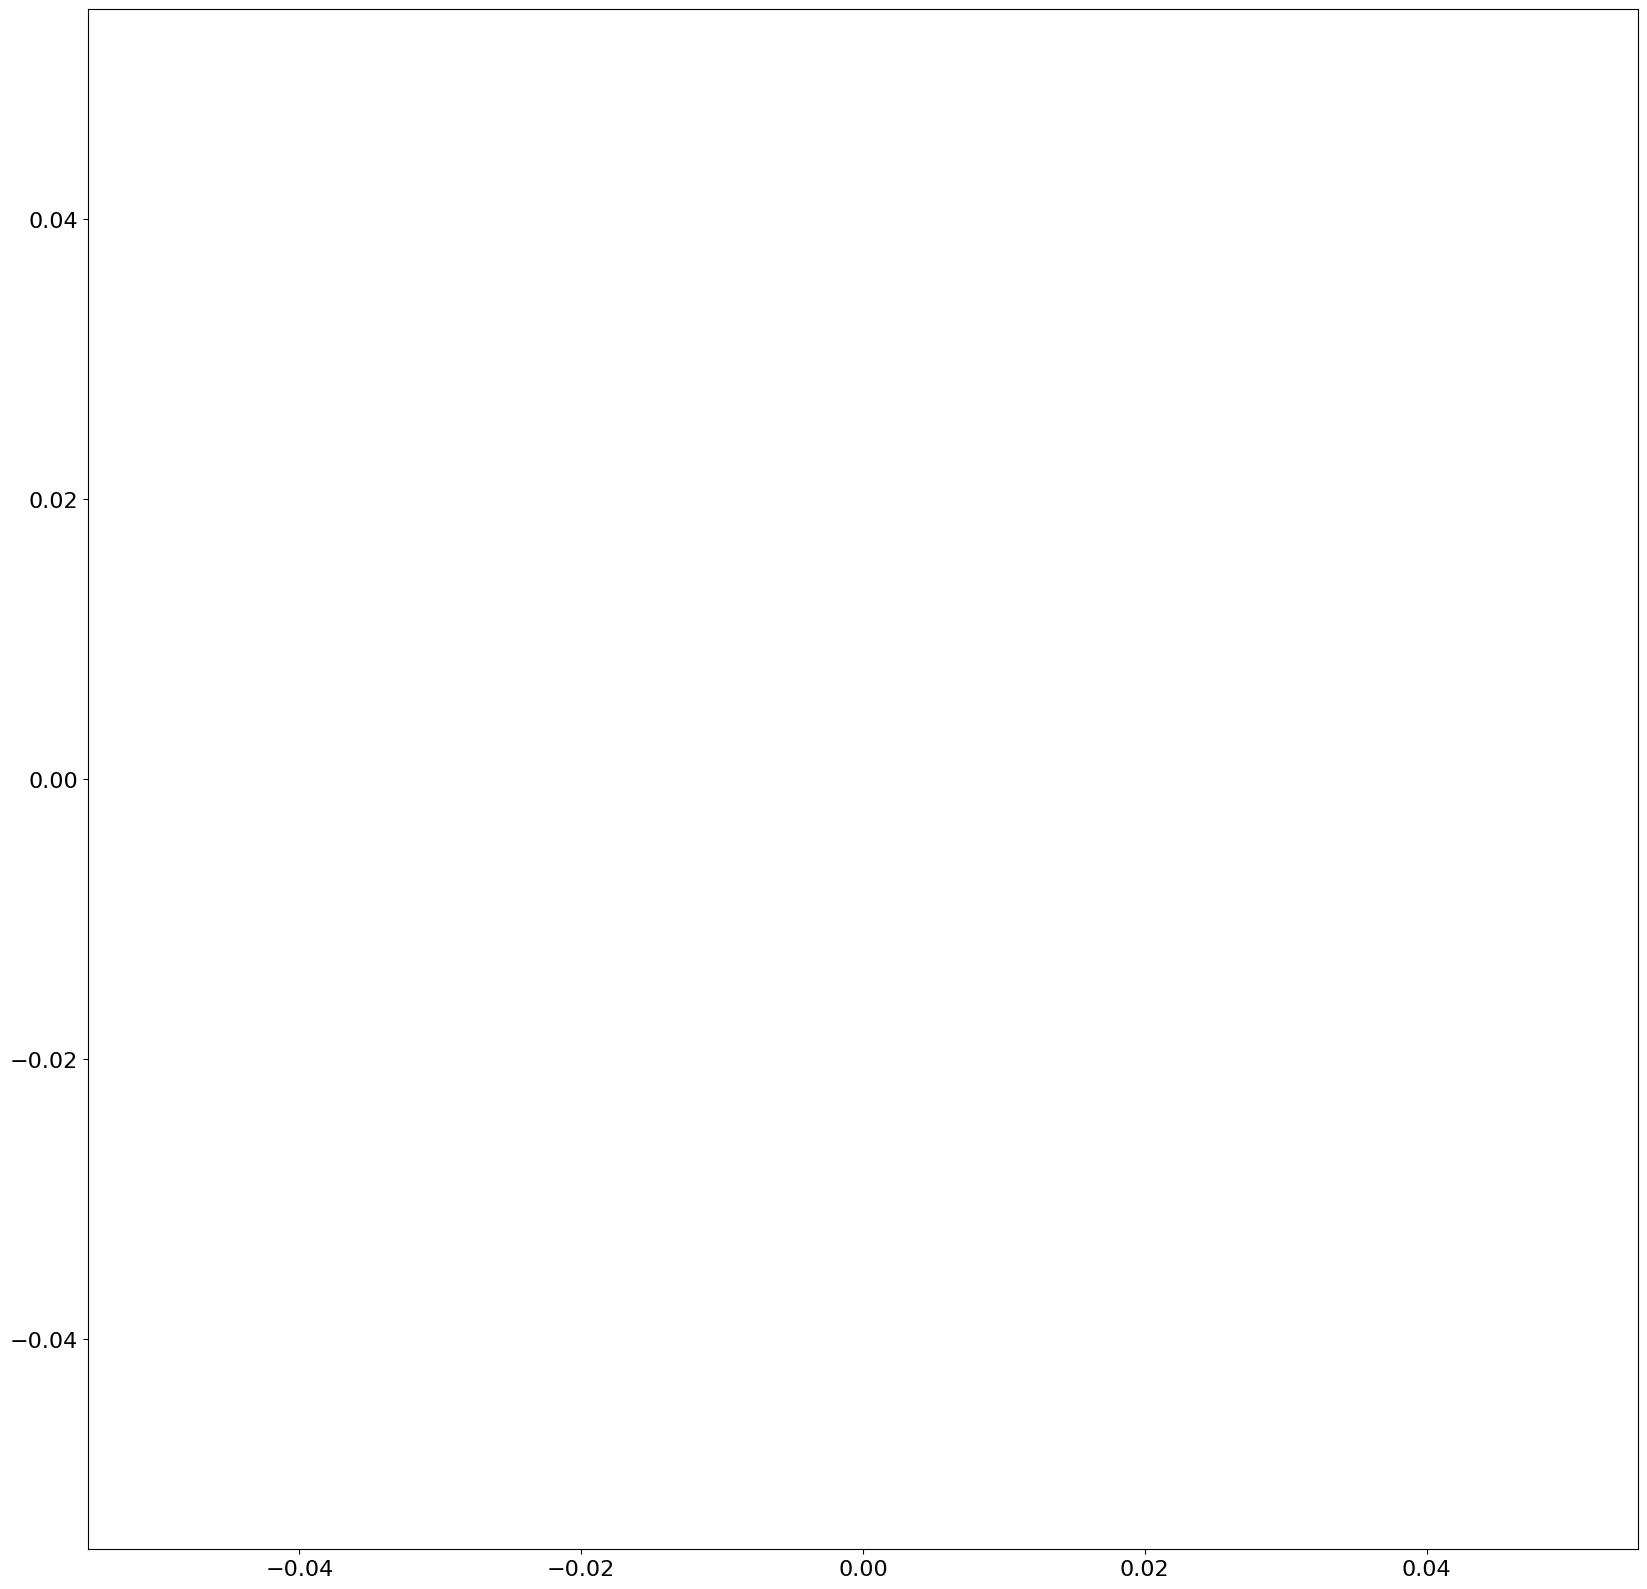

In [22]:
data_train = data_train.interpolate(method='time')
pass_value_barh(data_train)

#### Обработка пропусков test

Проверим пропуски в test:

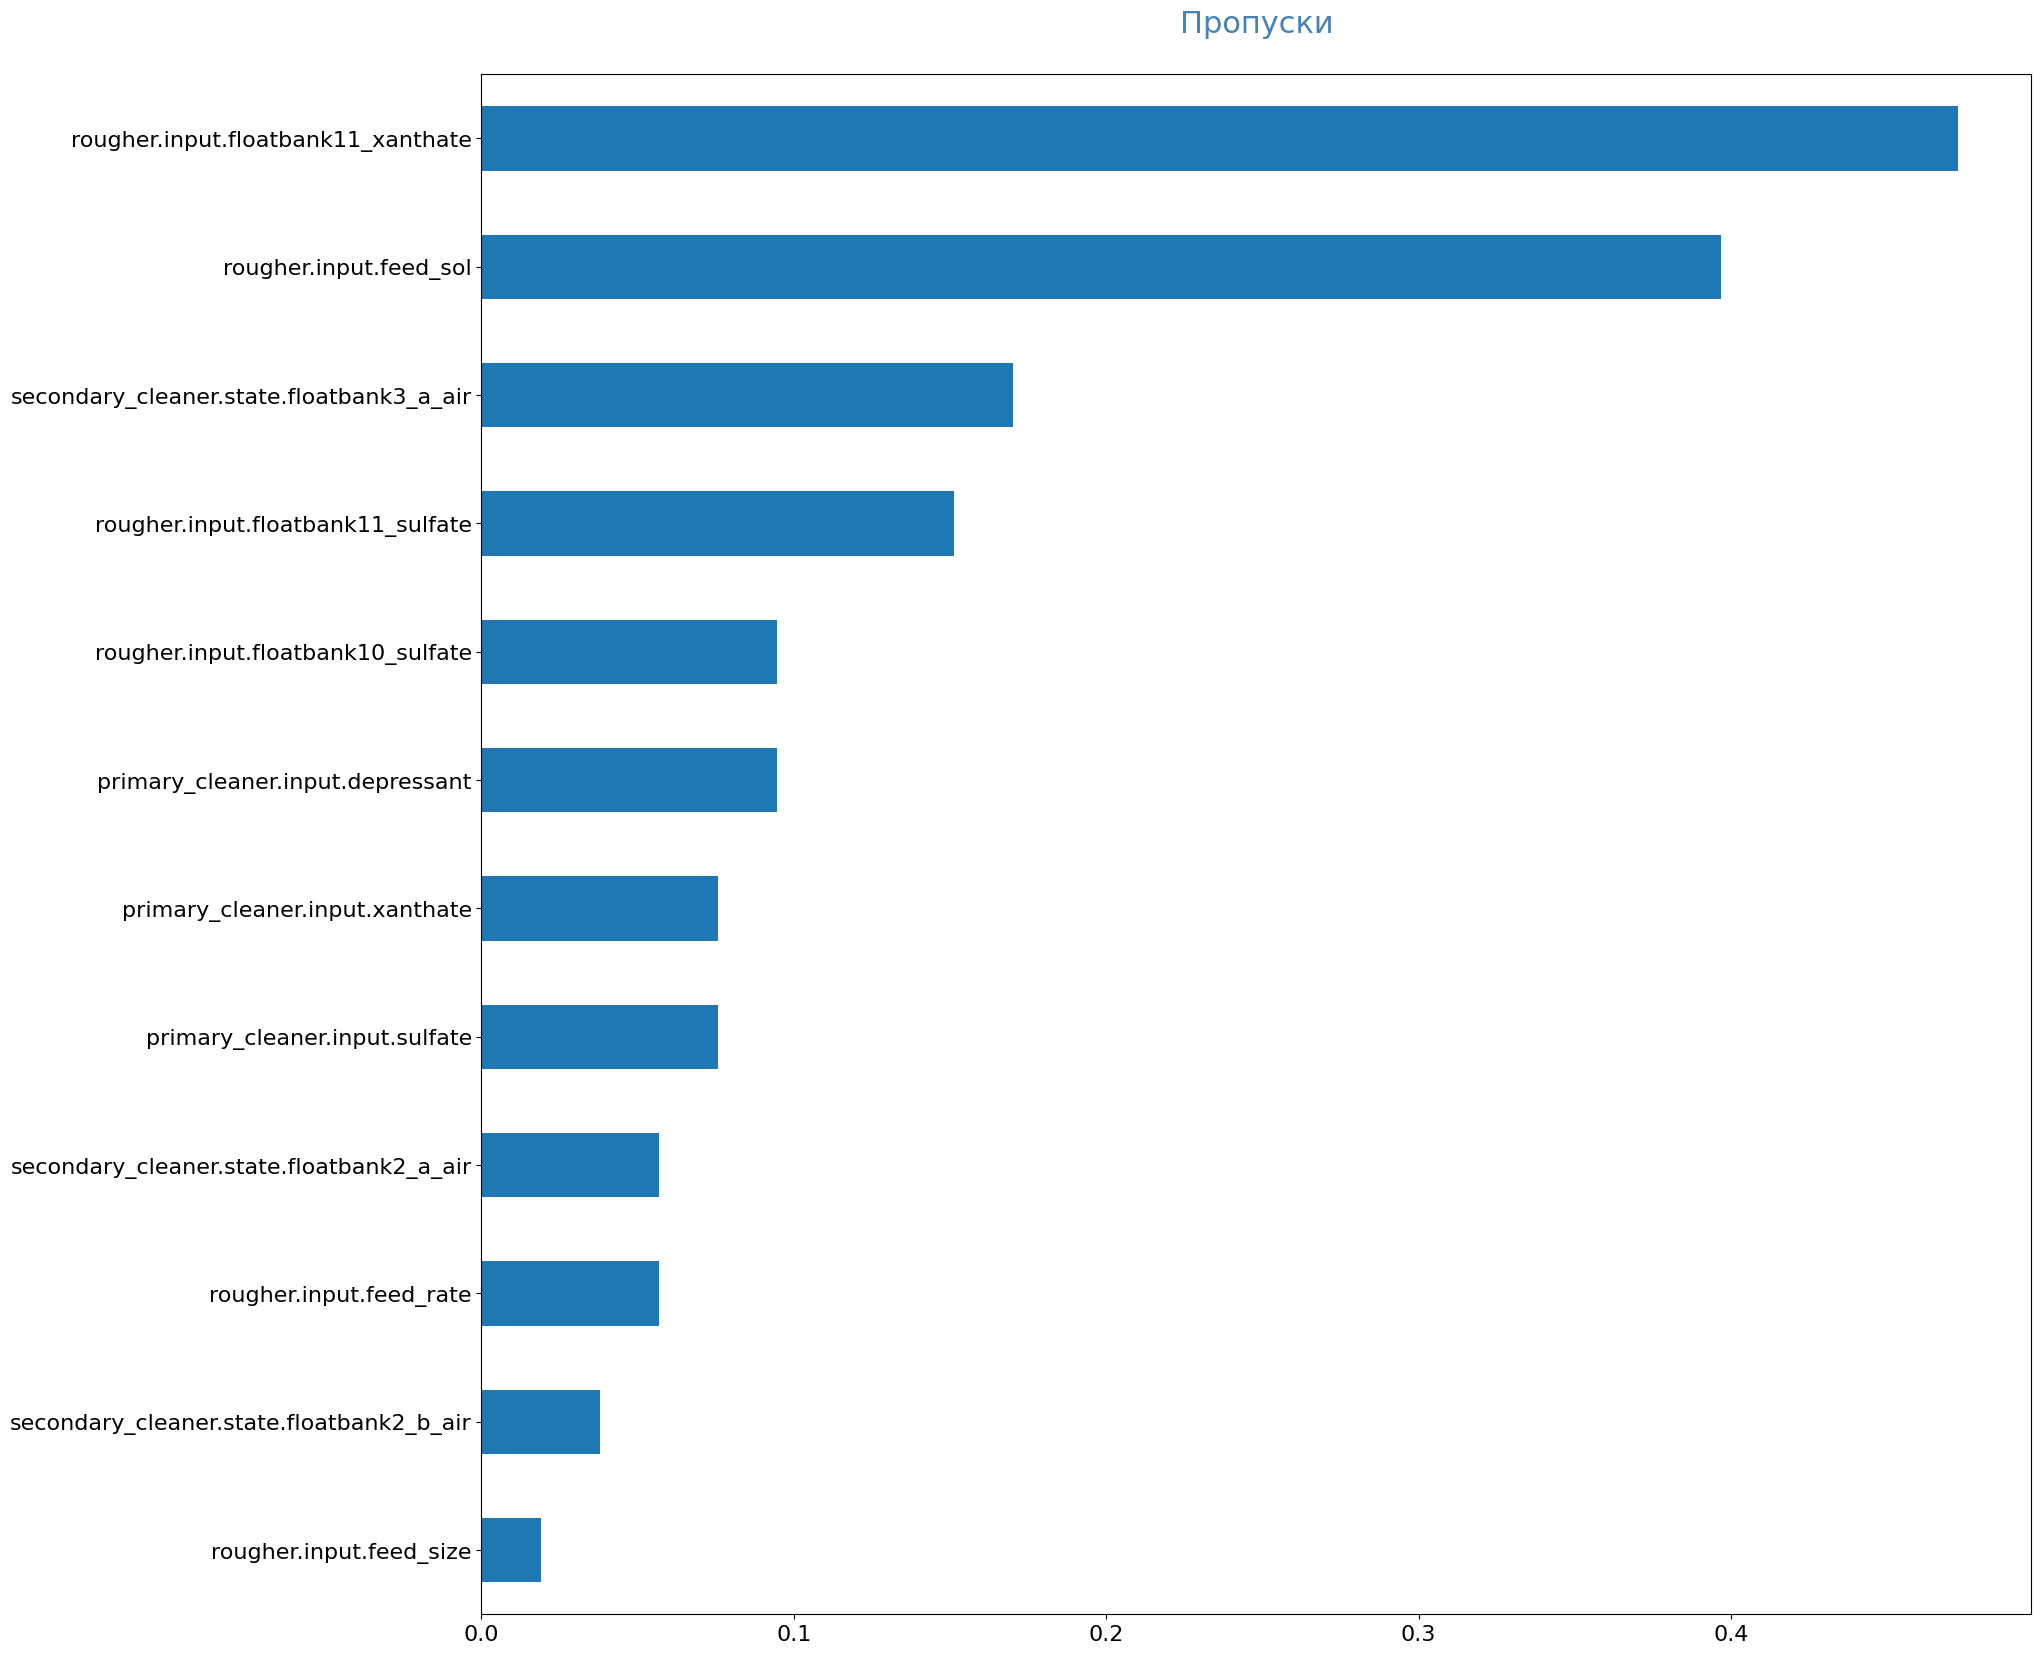

In [23]:
pass_value_barh(data_test)

Т.к. все наблюдения представляют собой последовательные измерения, заполнить пропуски можно методом interpolate (линейная интерполяция значений по времени наблюдений):

Пропусков не осталось


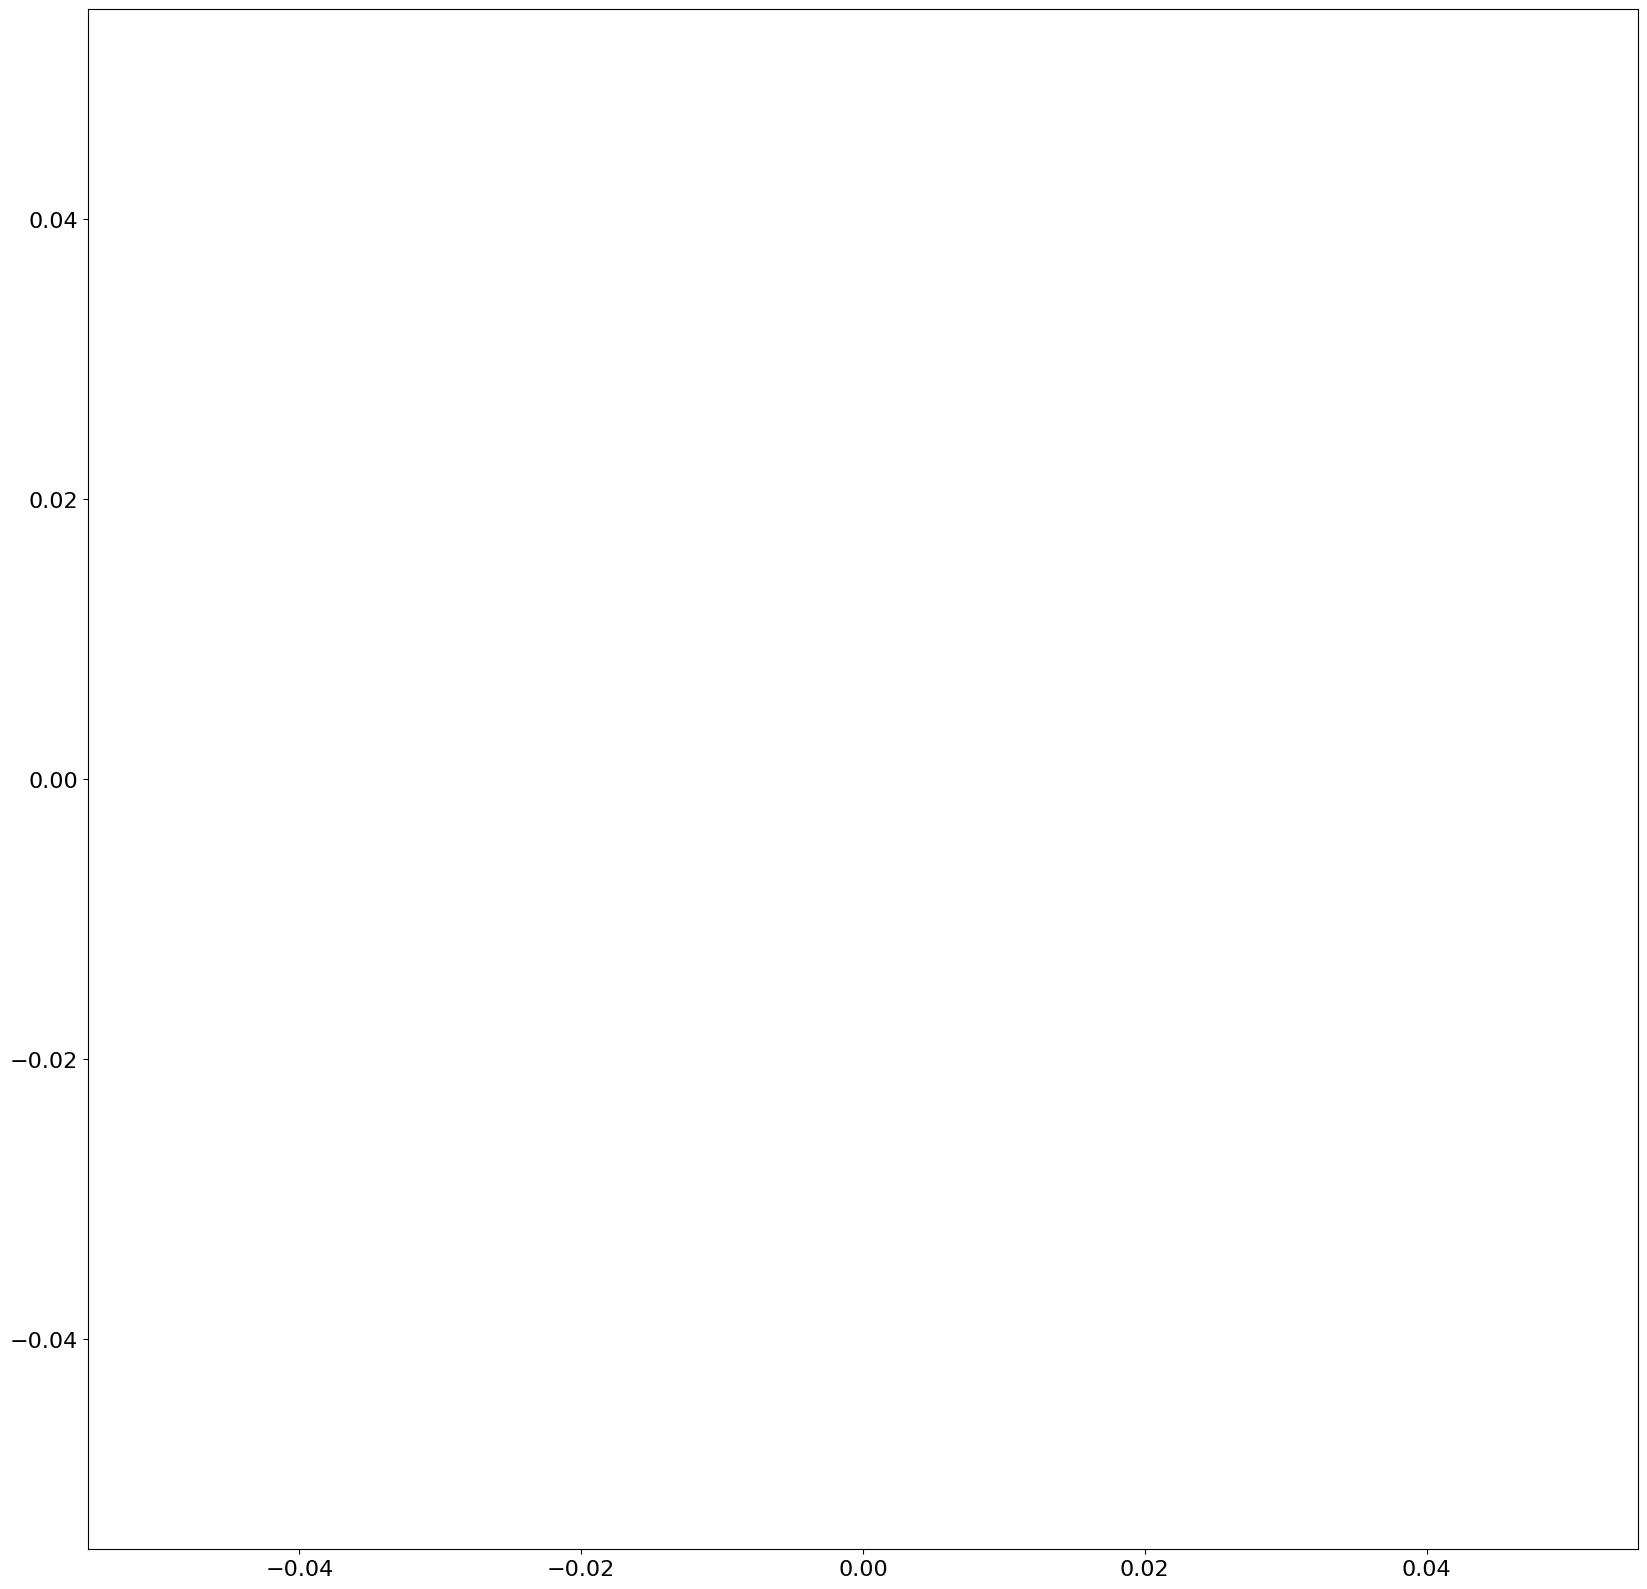

In [24]:
data_test = data_test.interpolate(method='time')
pass_value_barh(data_test)

**Вывод**: В тестовой выборке присутствуют только те параметры техпроцесса, которые мы можем получить непосредственно в ходе процесса или по его окончании. Все расчетные признаки из тестовой выборки мы удалили. Нули и пропуски в обучающей и тестовой выборках интерполировали по дате наблюдения.

## Анализ данных

### Анализ изменения концентрации металлов на разных этапах очистки

Будем строить гистограмму по полным данным, чтобы не добавлять недостающие признаки опять в train (которые мы удалили: которых нет в test).

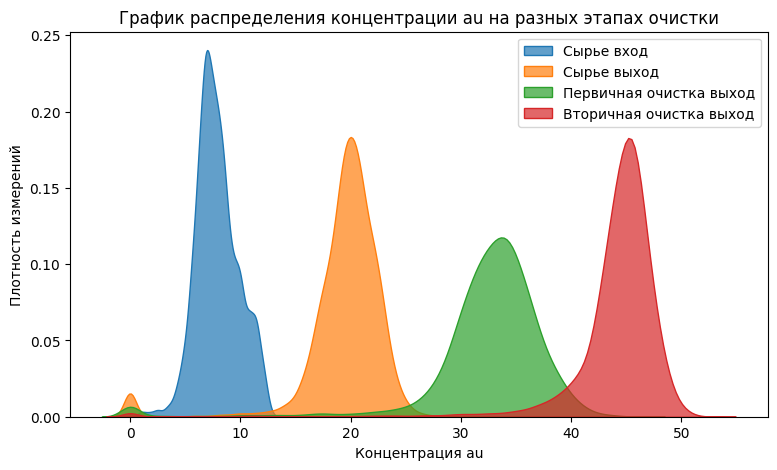

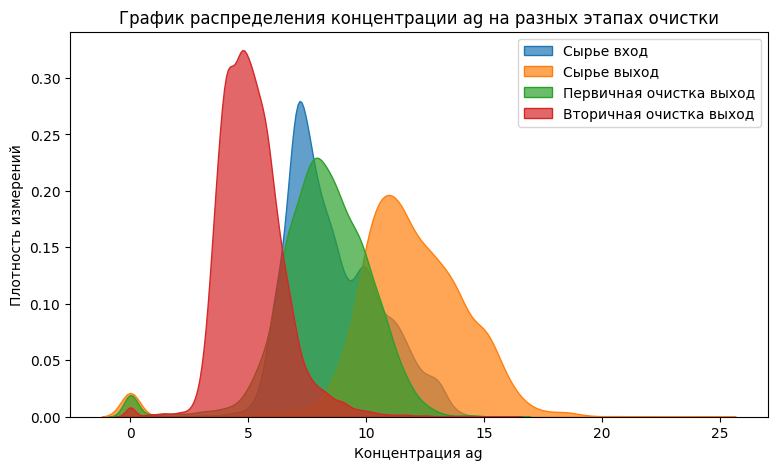

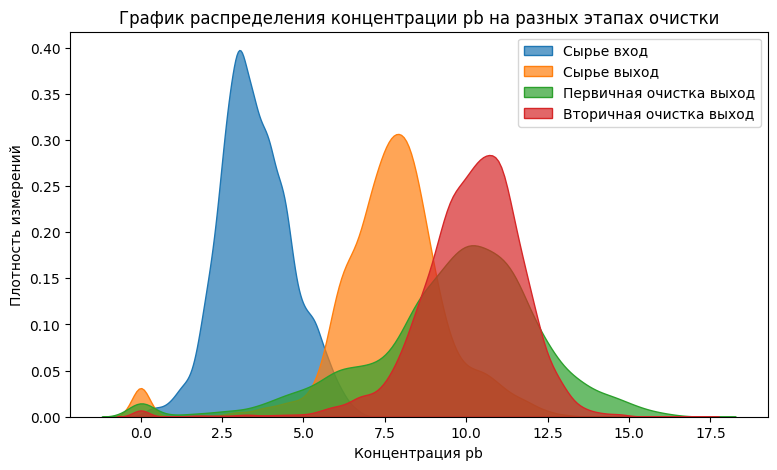

In [25]:
for metal in ['au', 'ag', 'pb']:
    data_train['rougher.output.concentrate_%s' % metal] = (data_full.loc[data_full.index.isin(data_train.index)]
                                                           ['rougher.output.concentrate_%s' % metal])
    data_train['primary_cleaner.output.concentrate_%s' % metal] = (data_full.loc[data_full.index.isin(data_train.index)]
                                                           ['primary_cleaner.output.concentrate_%s' % metal])
    data_train['final.output.concentrate_%s' % metal] = (data_full.loc[data_full.index.isin(data_train.index)]
                                                           ['final.output.concentrate_%s' % metal])
    
    plt.figure(figsize=(9,5))
    sns.kdeplot(data_train['rougher.input.feed_%s' % metal], fill=True, alpha=0.7)
    sns.kdeplot(data_train['rougher.output.concentrate_%s' % metal], fill=True, alpha=0.7)
    sns.kdeplot(data_train['primary_cleaner.output.concentrate_%s' % metal], fill=True, alpha=0.7)
    sns.kdeplot(data_train['final.output.concentrate_%s' % metal], fill=True, alpha=0.7)
    plt.legend(['Сырье вход', 'Сырье выход', 'Первичная очистка выход', 'Вторичная очистка выход'])
    plt.title('График распределения концентрации %s на разных этапах очистки' % metal)
    plt.xlabel('Концентрация %s' % metal)
    plt.ylabel('Плотность измерений')
    plt.show()

**Выводы:** Концентрация золота Au в сырье увеличивается с каждым этапом очистки, что ожидаемо и логично, ведь конечная цель всего технологического процесса - получение золота. Концентрация серебра Ag изменяется не так предсказуемо: концентрация увеличивается после флотации (обогащение не направлено на очистку драгоценных металлов от примесей). После первого и второго этапа очистки концентрация серебра резко падает. Скорее всего из-за того, что технологический процесс оптимизирован именно для золота - влияние очисток на концентрацию серебра вторично. Свинец Pb ведет себя почти также, как золото, за тем исключением, что после вторичной очистки его концентрация не увеличивается.  
Интересно, что есть пики нулевой концентрации по всем элементам. Вероятно, что есть строки, в которых суммарная концентрация всех элементов = 0 - будем считать такие строки выбросами и удалим (в 3-м пункте).

### Сравнение распределений размеров гранул на train и test

Сравним распределения размеров гранул сырья для этапа флотации:

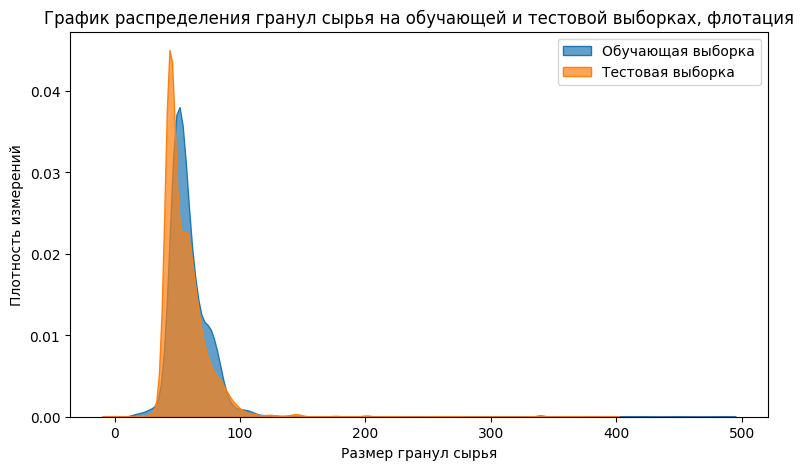

In [26]:
plt.figure(figsize=(9,5))
sns.kdeplot(data_train['rougher.input.feed_size'], fill=True, alpha=0.7)
sns.kdeplot(data_test['rougher.input.feed_size'], fill=True, alpha=0.7)
plt.legend(['Обучающая выборка', 'Тестовая выборка'])
plt.title('График распределения гранул сырья на обучающей и тестовой выборках, флотация')
plt.xlabel('Размер гранул сырья')
plt.ylabel('Плотность измерений')
plt.show()

Сравним распределения размеров гранул сырья для этапа первичной обработки:

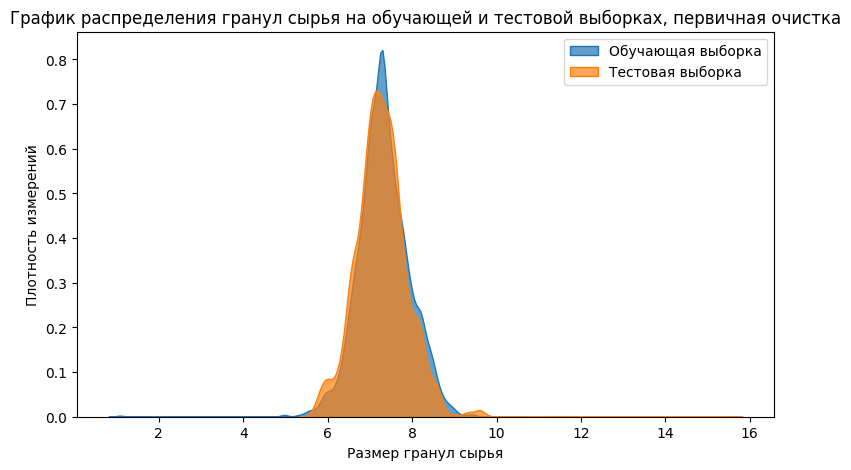

In [27]:
plt.figure(figsize=(9,5))
sns.kdeplot(data_train['primary_cleaner.input.feed_size'], fill=True, alpha=0.7)
sns.kdeplot(data_test['primary_cleaner.input.feed_size'], fill=True, alpha=0.7)
plt.legend(['Обучающая выборка', 'Тестовая выборка'])
plt.title('График распределения гранул сырья на обучающей и тестовой выборках, первичная очистка')
plt.xlabel('Размер гранул сырья')
plt.ylabel('Плотность измерений')
plt.show()

**Вывод:** По графикам плотности видно, что распределения гранул сырья на обучающей и тестовой выборках примерно похожи, следовательно, величины одинаково распределены. Небольшие расхождения не должны привести к существенной деградации модели из-за смещения данных (снижение метрик качества модели со временем из-за существенного изменения распределений признаков - data drift).

### Исследование суммарной концентрации веществ на разных стадиях

In [28]:
rougher_input = ['rougher.input.feed_au',
                 'rougher.input.feed_ag',
                 'rougher.input.feed_pb',
                 'rougher.input.feed_sol']

rougher_output = ['rougher.output.concentrate_au',
                  'rougher.output.concentrate_ag',
                  'rougher.output.concentrate_pb',
                  'rougher.output.concentrate_sol']

primary_cleaner = ['primary_cleaner.output.concentrate_au',
                   'primary_cleaner.output.concentrate_ag',
                   'primary_cleaner.output.concentrate_pb',
                   'primary_cleaner.output.concentrate_sol']

final = ['final.output.concentrate_au', 
         'final.output.concentrate_ag', 
         'final.output.concentrate_pb', 
         'final.output.concentrate_sol']

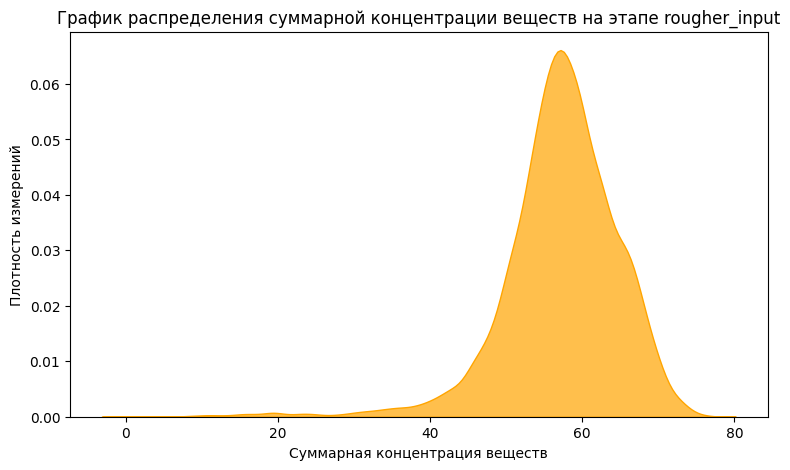

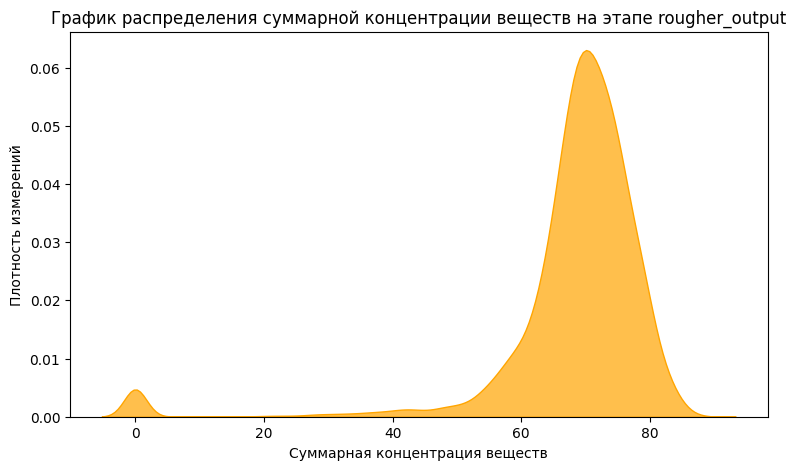

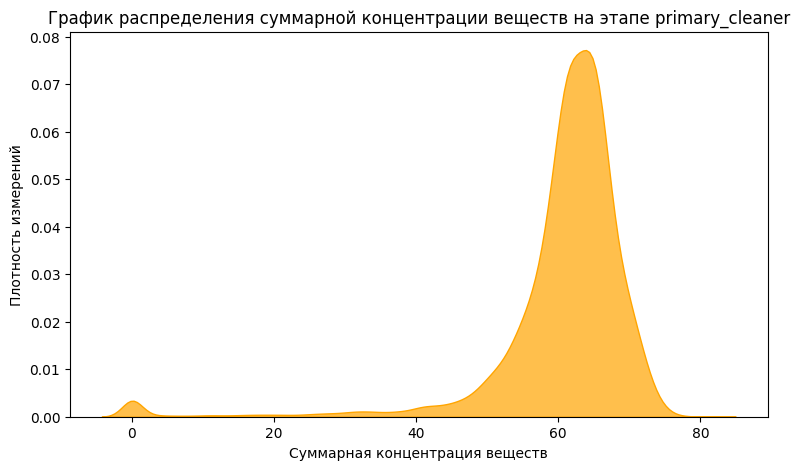

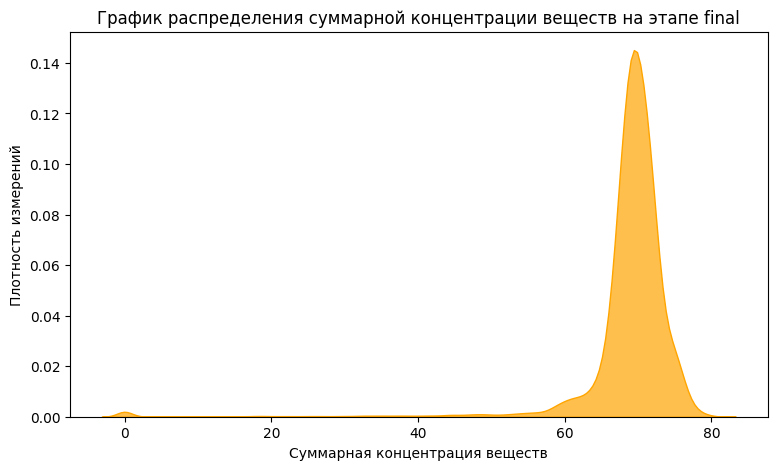

In [29]:
stages = [rougher_input, rougher_output, primary_cleaner, final]
stages_names = ['rougher_input', 'rougher_output', 'primary_cleaner', 'final']

for stage in stages:
    for name in stages_names:
        data_full['%s.output.concentrate_sum' % name] = data_full[stage].sum(axis=1)
    plt.figure(figsize=(9,5))
    sns.kdeplot(data_full['%s.output.concentrate_sum' % name], fill=True, alpha=0.7, color='orange')
    plt.title('График распределения суммарной концентрации веществ на этапе %s' % stages_names[stages.index(stage)])
    plt.xlabel('Суммарная концентрация веществ')
    plt.ylabel('Плотность измерений')
    plt.show()

**Вывод:** На всех стадиях кроме исходного сырья есть строки, где суммарная концентрация всех веществ = 0. С каждым этапом мода суммарной концентрации металлов почти не меняется и находится на уровне 60%-80% (в исходном сырье мода концентрации несколько меньше: порядка 55%). Зато видно, что "подрезаются хвосты": смесей, где суммарная концентрация веществ мала, становится меньше - скорее всего такие концентраты попадают в отвальные хвосты. Объем смеси уменьшается и на выходе мы видим, что плотность измерений увеличилась и финальная мода концентрации веществ стала равна 70% практически без хвостов.

Очистим датафрейм от строк, где суммарная концентрация металлов = 0 (они не несут в себе полезной для модели информации):

In [30]:
for name in stages_names:
    print(f'Кол-во строк до удаления нулевых суммарных концентраций: {len(data_full)}')
    data_full = data_full[data_full['%s.output.concentrate_sum' % name] != 0]
    print(f'Кол-во строк после удаления нулевых суммарных концентраций: {len(data_full)}')
    print()

Кол-во строк до удаления нулевых суммарных концентраций: 19439
Кол-во строк после удаления нулевых суммарных концентраций: 19341

Кол-во строк до удаления нулевых суммарных концентраций: 19341
Кол-во строк после удаления нулевых суммарных концентраций: 19341

Кол-во строк до удаления нулевых суммарных концентраций: 19341
Кол-во строк после удаления нулевых суммарных концентраций: 19341

Кол-во строк до удаления нулевых суммарных концентраций: 19341
Кол-во строк после удаления нулевых суммарных концентраций: 19341



Очистим обучающую и тестовую выборки от тех же строк, в которых суммарные концентрации равны нулю:

In [31]:
print(data_train.shape)
data_train = data_train.loc[data_train.index.isin(data_full.index)]
print(data_train.shape)

print()

print(data_test.shape)
data_test = data_test.loc[data_test.index.isin(data_full.index)]
print(data_test.shape)

(14149, 63)
(14091, 63)

(5290, 54)
(5250, 54)


**Вывод:** Исходный датасет содержал строки с нулевым суммарным значением концентраций всех элементов. Мы удалили эти строки, т.к. данные явно не корректные и заполнить концентрации какими-либо значениями корректно без дополнительной информации мы не можем. 

## Построение модели

Сначала еще раз проверим наличие в train столбцов, которых нет в test:

In [32]:
train_col_list = list(data_train.columns)
test_col_list = list(data_test.columns)

mismatches_train_test = []

for i in range(len(train_col_list)):
    if train_col_list[i] not in test_col_list:
        mismatches_train_test.append(train_col_list[i])

        
print(f'Всего столбцов в train: {len(train_col_list)}')
print(f'Всего столбцов в test: {len(test_col_list)}')
print('Следующих столбцов нет в датафрейме data_test: ')
mismatches = pd.DataFrame(mismatches_train_test, columns=['train_test_mismatches'])

mismatches

Всего столбцов в train: 63
Всего столбцов в test: 54
Следующих столбцов нет в датафрейме data_test: 


train_test_mismatches
0          rougher.output.concentrate_au
1  primary_cleaner.output.concentrate_au
2            final.output.concentrate_au
3          rougher.output.concentrate_ag
4  primary_cleaner.output.concentrate_ag
5            final.output.concentrate_ag
6          rougher.output.concentrate_pb
7  primary_cleaner.output.concentrate_pb
8            final.output.concentrate_pb

Из train удалим все столбцы, которых нет в test:

In [33]:
data_train = data_train.drop(columns = list(mismatches.train_test_mismatches))

print(f'Всего столбцов в train: {len(list(data_train.columns))}')
print(f'Всего столбцов в test: {len(list(data_test.columns))}')

Всего столбцов в train: 54
Всего столбцов в test: 54


Проверим наличие таргетов в train:

In [34]:
print(data_train['rougher.output.recovery'].head(3))
print(data_train['final.output.recovery'].head(3))

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
Name: rougher.output.recovery, dtype: float64
date
2016-01-15 00:00:00    70.541216
2016-01-15 01:00:00    69.266198
2016-01-15 02:00:00    68.116445
Name: final.output.recovery, dtype: float64


Проверим отсутствие таргетов в test:

In [35]:
print(data_test['rougher.output.recovery'].head(3))
print(data_test['final.output.recovery'].head(3))

date
2016-09-01 00:59:59    89.993421
2016-09-01 01:59:59    88.089657
2016-09-01 02:59:59    88.412756
Name: rougher.output.recovery, dtype: float64
date
2016-09-01 00:59:59    70.273583
2016-09-01 01:59:59    68.910432
2016-09-01 02:59:59    68.143213
Name: final.output.recovery, dtype: float64


Таргеты оставляем.

Теперь можно приступать к выбору моделей.

### Функции для вычисления итоговой sMAPE

sMAPE - симметричное среднее абсолютное процентное отклонение. Выражается в относительных величинах, одинаково учитывает масштаб и целевого признака, и предсказания.  
Функция вычисления sMAPE для каждого этапа по отдельности:

In [36]:
def sMAPE(target, predictions):
    return np.mean(2 * abs(target - predictions) / (abs(target) + abs(predictions))) * 100

Функция вычисления итоговой метрики sMAPE:

In [37]:
def sMAPE_final(metric_rough, metric_fin):
    return 0.25 * metric_rough + 0.75 * metric_fin

### Выбор модели

Настраивать модель (подбирать гиперпараметры) будем при помощи RandomizedSearchCV, чтобы не перебирать все возможные комбинации и не занимать время. Разбивать на обучающую и валидационную выборки обучающий набор также отдельно не будем, т.к. RandomizedSearchCV разбивает на подвыборки внутри себя (плюс у нас сразу будет кросс-валидация). Обучать модели будем сразу для двух таргетов.

Т.к. метрики sMAPE нет в RandomizedSearchCV, создадим свою собственную метрику для передачи в RandomizedSearchCV. `greater_is_better` установим False, т.к. по модулю нам лучше получить меньшее значение метрики - меньшее среднее абсолютное процентное отклонение.

In [38]:
smape_score = make_scorer(sMAPE, greater_is_better = False)

Сделаем предобработку числовых столбцов. Т.к. в нашей задаче разброс значений в количественных признаках большой (разница в несколько разрядов по отдельным столбцам), приведем все количественнные признаки к одному масштабу. Количественные признаки распределены нормально, поэтому воспользуемся стандартизацией данных.

In [39]:
preprocessor = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

Выделим features и targets в отдельные переменные:

In [40]:
features_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher_train = data_train['rougher.output.recovery']
target_final_train = data_train['final.output.recovery']
features_test = data_test
target_rougher_test = data_full.loc[data_full.index.isin(data_test.index)]['rougher.output.recovery']
target_final_test = data_full.loc[data_full.index.isin(data_test.index)]['final.output.recovery']

#### Линейная регрессия

Создадим объект LinearRegression. У линейной регрессии нет гиперпараметров, которые можно было бы настроить, поэтому зададим пустое множество:

In [41]:
model = LinearRegression()
parameters = {}

Создаем пайплайн и настраиваем модель при помощи RandomizedSearchCV

In [42]:
pipe = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('regression', LinearRegression())]
)

clf = RandomizedSearchCV(pipe, 
                         parameters, 
                         scoring=smape_score, 
                         cv=3, 
                         random_state=42,
                         n_jobs=-1,
                         verbose=10
                        )

clf.fit(features_train, target_rougher_train)
smape_rougher_lr = clf.best_score_

clf.fit(features_train, target_final_train)
smape_final_lr = clf.best_score_

smape_result_lr = sMAPE_final(smape_rougher_lr, smape_final_lr)

print("sMAPE_rougher для линейной регрессии на обучающем датасете", round(-smape_rougher_lr, ndigits=3))
print("sMAPE_final для линейной регрессии на обучающем датасете", round(-smape_final_lr, ndigits=3))
print("Итоговое sMAPE для линейной регрессии на обучающем датасете", round(-smape_result_lr, ndigits=3))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
sMAPE_rougher для линейной регрессии на обучающем датасете 17.258
sMAPE_final для линейной регрессии на обучающем датасете 13.958
Итоговое sMAPE для линейной регрессии на обучающем датасете 14.783


#### Дерево решений

Создадим объект DecisionTreeRegressor и определим параметры, которые мы будем перебирать при настройке дерева решений:

In [43]:
model = DecisionTreeRegressor(random_state=42)

param_grid_tree = [    
    {'tree__splitter' : ['best', 'random'],
     'tree__max_depth' : list(range(1,41)),
     'tree__min_samples_leaf' : list(range(1, 21)),
     'tree__min_samples_split' : list(range(1,41))
    }
]

Создаем пайплайн и настраиваем модель при помощи RandomizedSearchCV

In [44]:
pipe = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('tree', DecisionTreeRegressor(random_state=42))]
)

clf = RandomizedSearchCV(pipe, 
                         param_distributions=param_grid_tree, 
                         scoring=smape_score, 
                         cv=3, 
                         random_state=42,
                         n_iter=70,
                         n_jobs=-1,
                         verbose=10
                        )

clf.fit(features_train, target_rougher_train)
smape_rougher_tree = clf.best_score_

clf.fit(features_train, target_final_train)
smape_final_tree = clf.best_score_

smape_result_tree = sMAPE_final(smape_rougher_tree, smape_final_tree)

print("Tuned Hyperparameters :", clf.best_params_)

print("sMAPE_rougher для дерева решений на обучающем датасете", round(-smape_rougher_tree, ndigits=3))
print("sMAPE_final для дерева решений на обучающем датасете", round(-smape_final_tree, ndigits=3))
print("Итоговое sMAPE для дерева решений на обучающем датасете", round(-smape_result_tree, ndigits=3))

Fitting 3 folds for each of 70 candidates, totalling 210 fits
Fitting 3 folds for each of 70 candidates, totalling 210 fits
Tuned Hyperparameters : {'tree__splitter': 'best', 'tree__min_samples_split': 31, 'tree__min_samples_leaf': 11, 'tree__max_depth': 1}
sMAPE_rougher для дерева решений на обучающем датасете 12.257
sMAPE_final для дерева решений на обучающем датасете 10.333
Итоговое sMAPE для дерева решений на обучающем датасете 10.814


#### Случайный лес

Создадим объект RandomForestRegressor и определим параметры, которые мы будем перебирать при настройке случайного леса:

In [45]:
model = RandomForestRegressor(random_state=42)

param_grid_forest = [    
    {'forest__n_estimators' : list(range(10, 51, 10)), 
     'forest__max_depth' : list(range(1, 31)), 
     'forest__min_samples_leaf' : list(range(1, 21)), 
     'forest__min_samples_split' : list(range(2,41))
    }
]

Создаем пайплайн и настраиваем модель при помощи RandomizedSearchCV

In [46]:
pipe = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('forest', RandomForestRegressor(random_state=42))]
)

clf = RandomizedSearchCV(pipe, 
                         param_distributions=param_grid_forest, 
                         scoring=smape_score, 
                         cv=3, 
                         random_state=42,
                         n_iter=70,
                         n_jobs=-1,
                         verbose=10
                        )

clf.fit(features_train, target_rougher_train)
smape_rougher_forest = clf.best_score_

clf.fit(features_train, target_final_train)
smape_final_forest = clf.best_score_

smape_result_forest = sMAPE_final(smape_rougher_forest, smape_final_forest)

print("Tuned Hyperparameters :", clf.best_params_)

print("sMAPE_rougher для случайного леса на обучающем датасете", round(-smape_rougher_forest, ndigits=3))
print("sMAPE_final для случайного леса на обучающем датасете", round(-smape_final_forest, ndigits=3))
print("Итоговое sMAPE для случайного леса на обучающем датасете", round(-smape_result_forest, ndigits=3))

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[CV 2/3; 3/70] START tree__max_depth=1, tree__min_samples_leaf=11, tree__min_samples_split=31, tree__splitter=best
[CV 2/3; 3/70] END tree__max_depth=1, tree__min_samples_leaf=11, tree__min_samples_split=31, tree__splitter=best;, score=-12.416 total time=   0.0s
[CV 2/3; 5/70] START tree__max_depth=40, tree__min_samples_leaf=3, tree__min_samples_split=6, tree__splitter=best
[CV 2/3; 5/70] END tree__max_depth=40, tree__min_samples_leaf=3, tree__min_samples_split=6, tree__splitter=best;, score=-14.604 total time=   0.6s
[CV 2/3; 10/70] START tree__max_depth=4, tree__min_samples_leaf=19, tree__min_samples_split=13, tree__splitter=random
[CV 2/3; 10/70] END tree__max_depth=4, tree__min_samples_leaf=19, tree__min_samples_split=13, tree__splitter=random;, score=-13.569 total time=   0.0s
[CV 3/3; 10/70] START tree__max_depth=4, tree__min_samples_leaf=19, tree__min_samples_split=13, tree__splitter=random
[CV 3/3; 10/70] END tree__m

#### Выбор лучшей модели

Сравним модели:

In [47]:
results = {'' : ['LinearRegression', 
                 'DecisionTreeRegressor', 
                 'RandomForestRegressor'],
          'sMAPE (rougher)' : [round(-smape_rougher_lr, ndigits=4), 
                               round(-smape_rougher_tree, ndigits=4), 
                               round(-smape_rougher_forest, ndigits=4)],
          'sMAPE (final)' : [round(-smape_final_lr, ndigits=4), 
                               round(-smape_final_tree, ndigits=4), 
                               round(-smape_final_forest, ndigits=4)],
          'sMAPE (result)' : [round(-smape_result_lr, ndigits=4), 
                               round(-smape_result_tree, ndigits=4), 
                               round(-smape_result_forest, ndigits=4)]}

pd.DataFrame(results).sort_values('sMAPE (result)', ascending=True)

sMAPE (rougher)  sMAPE (final)  sMAPE (result)
2  RandomForestRegressor          11.8123        10.2700         10.6556
1  DecisionTreeRegressor          12.2571        10.3331         10.8141
0       LinearRegression          17.2576        13.9581         14.7830

Лучшая модель - RandomForestRegressor с гиперпараметрами:    
{'forest__n_estimators': 30, 'forest__min_samples_split': 5, 'forest__min_samples_leaf': 15, 'forest__max_depth': 1} 

Она дает наименьшее итоговое симметричное среднее абсолютное процентное отклонение. Проверим данную модель на тестовой выборке.

#### Проверка на тестовой выборке

Еще раз обозначим признаки и таргеты:

Проверим наличие таргетов в features_test:

In [48]:
features_test = features_test.drop(columns = ['rougher.output.recovery', 'final.output.recovery'])

try:
    print(features_test['rougher.output.recovery'].head(3))
    print(features_test['final.output.recovery'].head(3))
except:
    print('Таргеты удалены')

Таргеты удалены


Теперь проверяем модель:

In [49]:
pipe = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('forest', RandomForestRegressor(random_state=42, 
                                            n_estimators=30, 
                                            min_samples_split=5, 
                                            min_samples_leaf=15, 
                                            max_depth=1, 
                                            n_jobs=-1))]
)

pipe.fit(features_train, target_rougher_train)
predictions_rougher_test = pipe.predict(features_test)

sMAPE_rougher = sMAPE(target_rougher_test, predictions_rougher_test)

pipe.fit(features_train, target_final_train)
predictions_final_test = pipe.predict(features_test)

sMAPE_fin = sMAPE(target_final_test, predictions_final_test)

sMAPE_test = sMAPE_final(sMAPE_rougher, sMAPE_fin)

print(f'sMAPE_rougher на обучающей выборке: {-smape_rougher_forest}')
print(f'sMAPE_rougher на тестовой выборке: {sMAPE_rougher}')
print()
print(f'sMAPE_final на обучающей выборке: {-smape_final_forest}')
print(f'sMAPE_final на тестовой выборке: {sMAPE_fin}')
print()
print(f'sMAPE_result на обучающей выборке: {-smape_result_forest}')
print(f'sMAPE_result на тестовой выборке: {sMAPE_test}')

sMAPE_rougher на обучающей выборке: 11.812317260818423
sMAPE_rougher на тестовой выборке: 10.819654409190022

sMAPE_final на обучающей выборке: 10.270048022871729
sMAPE_final на тестовой выборке: 8.067342288513936

sMAPE_result на обучающей выборке: 10.655615332358403
sMAPE_result на тестовой выборке: 8.755420318682958


На тестовой выборке результирующий sMAPE оказался чуть лучше, чем на обучающей.

Проверим модель на адекватность при помощи константной модели DummyRegressor:

In [50]:
pipe_dummy = Pipeline(
    steps=[('preprocessor', preprocessor), 
           ('dummy', DummyRegressor(strategy='mean'))]
)

pipe_dummy.fit(features_train, target_rougher_train)
predictions_rougher_test_dummy = pipe_dummy.predict(features_test)

sMAPE_rougher_dummy = sMAPE(target_rougher_test, predictions_rougher_test_dummy)

pipe_dummy.fit(features_train, target_final_train)
predictions_final_test_dummy = pipe_dummy.predict(features_test)

sMAPE_fin_dummy = sMAPE(target_final_test, predictions_final_test_dummy)

sMAPE_test_dummy = sMAPE_final(sMAPE_rougher_dummy, sMAPE_fin_dummy)

print(f'sMAPE_result случайного леса на тестовой выборке: {sMAPE_test}')
print(f'sMAPE_result константной модели на тестовой выборке: {sMAPE_test_dummy}')

sMAPE_result случайного леса на тестовой выборке: 8.755420318682958
sMAPE_result константной модели на тестовой выборке: 9.04758123792081


Метрика на константной модели (при предсказании средним) хуже, чем метрика sMAPE для случайного леса. Работа проделана не зря - мы можем использовать модель случайного леса с подобранными гиперпараметрами для предсказания эффективности обогащения чернового и финального концентрата.

## Выводы

Была поставлена задача по подготовке прототипа модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды. Для работы были предоставлены данные с параметрами добычи и очистки.  
  
В тестовой выборке не были доступны расчетные характеристики этапа флотации и не было никаких выходных данных на разных этапах технологического процесса - в связи с этим для предварительного анализа и последующего обучения модели мы эти данные не брали.  
  
В исходном датафрейме (full) было не так много пропущенных значений, но при этом, что было интереснее, были нули. Например, суммарная концентрация всех веществ в нескольких десятках строк равна нулю. Интересно было бы узнать причину таких цифр.  
Пропуски мы заполнили интерполяцией по времени наблюдений.  
  
При анализе очищенных данных выяснилось, что в отличии от золота и свинца, концентрация которых в сырье увеличивается с каждым этапом очистки (но стоит отметить, что концентрация свинца после вторичной очистки не увеличивается), концентрация серебра начинает резко уменьшаться после второго этапа. Можно рассмотреть данный момент в качестве отдельной задачи - посмотреть, могли бы мы в том же технологическом процессе по получению золота максимально эффективно извлекать и серебро без потерь.  
  
Для построения и выбора модели была выбрана метрика sMAPE - симметричное среднее абсолютное процентное отклонение. После оценки трех моделей: линейной регрессии, дерева решений и случайного леса, с учетом кросс-валидации (10 фолдов) во всех трех случаях, мы получили наилучший результат на модели случайного леса: итоговый sMAPE на обучающей выборке 9.547. Худший результат дала линейная регрессия - 10.6 на обучающей выборке. Мы проверили модель случайного леса на тестовой выборке и получили итоговый sMAPE 8.75 - лучше, чем на обучающей выборке, в связи с тем, что в test не так много данных, поэтому разброс меньше.